# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY-small.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [8]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

In [9]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by LinearDiscriminantAnalysis.

<Figure size 640x480 with 0 Axes>

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

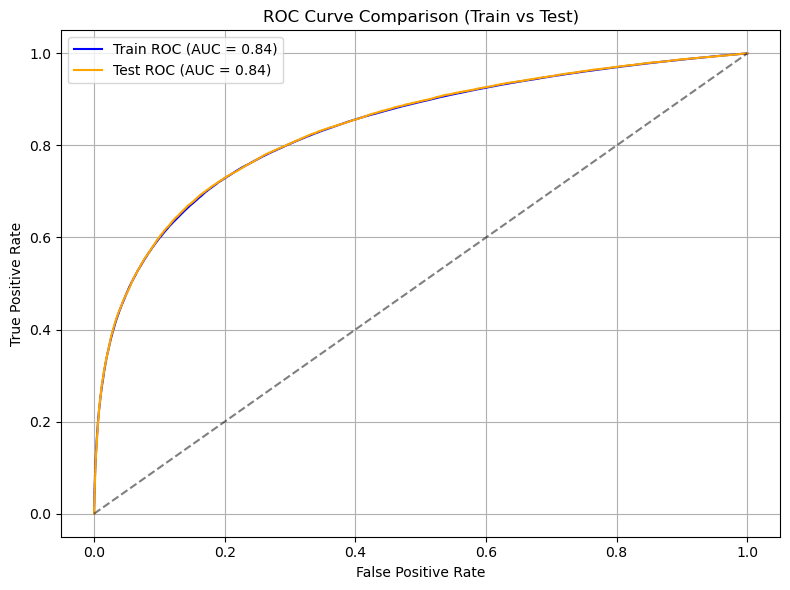

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score,
    f1_score, accuracy_score
)

# ROC for training and testing samples
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', label=f"Train ROC (AUC = {roc_auc_train:.2f})")
plt.plot(fpr_test, tpr_test, color='orange', label=f"Test ROC (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Train vs Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

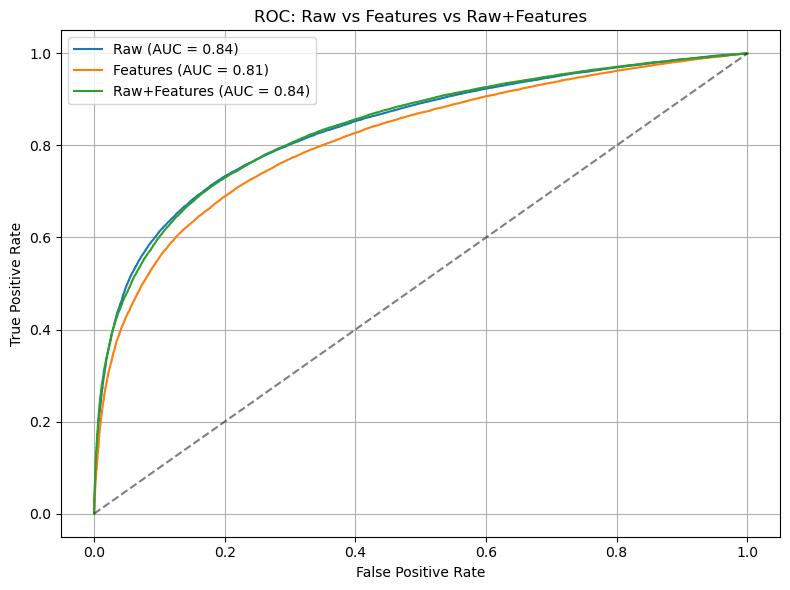

In [15]:
raw_features = VarNames[1:11]
derived_features = VarNames[11:]
all_features = VarNames[1:]

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    y_scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    return fpr, tpr, auc(fpr, tpr)

results = {}
for label, features in zip(["Raw", "Features", "Raw+Features"],
                           [raw_features, derived_features, all_features]):
    fpr, tpr, roc_auc = train_and_evaluate(Train_Sample[features], Test_Sample[features],
                                           y_Train, y_Test)
    results[label] = (fpr, tpr, roc_auc)

# Plot
plt.figure(figsize=(8,6))
for label, (fpr, tpr, roc_auc) in results.items():
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Raw vs Features vs Raw+Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [23]:
models = {
    "LDA": LinearDiscriminantAnalysis(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=10),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50, max_depth=3)
}

# Evaluation function
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    n_s = np.sum((y_score > 0.5) & (y_test == 1))
    n_b = np.sum((y_score > 0.5) & (y_test == 0))
    significance = n_s / np.sqrt(n_s + n_b) if (n_s + n_b) > 0 else 0
    return {
        "Model": name,
        "AUC": auc_score,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Accuracy": acc,
        "Significance": significance
    }

# Run evaluations
results = [evaluate_model(name, model, X_Train, X_Test, y_Train, y_Test)
           for name, model in models.items()]
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.set_index("Model")
print(metrics_df.round(3))

                      AUC  Precision  Recall     F1  Accuracy  Significance
Model                                                                      
LDA                 0.838      0.848   0.577  0.687     0.758       149.966
LogisticRegression  0.859      0.831   0.677  0.746     0.788       160.778
RandomForest        0.865      0.830   0.694  0.756     0.794       162.678
GradientBoosting    0.866      0.821   0.704  0.758     0.794       163.018


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

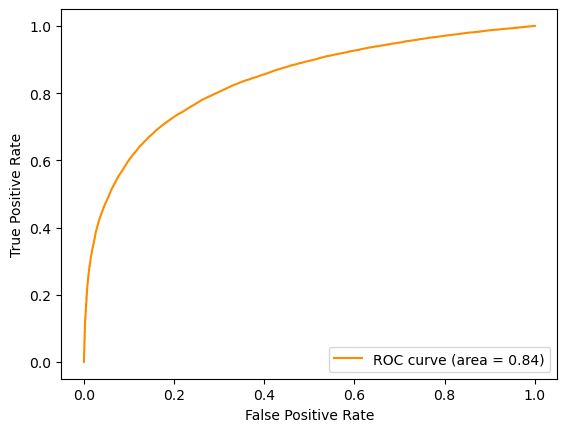

In [24]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 
